# Imports

In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from PIL import Image
import shutil
import torch
from torch import nn
from collections import OrderedDict
from efficientnet.tfkeras import EfficientNetB3
from tensorflow.keras.applications import ResNet50

In [3]:
pip install efficientnet

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/50.7 kB ? eta -:--:--
     -------- ------------------------------- 10.2/50.7 kB ? eta -:--:--
     -------------------------------------- 50.7/50.7 kB 860.9 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Datasets paths

In [2]:
train = "/kaggle/input/brain-tumor-mri-dataset/Training"
test = "/kaggle/input/brain-tumor-mri-dataset/Testing"

# Extract Files

In [3]:
train_path = []
train_class = []
test_path = []
test_class = []

train_dir = os.listdir(train)
test_dir = os.listdir(test)

for dir in train_dir:    
    sub_train_path = os.path.join(train, dir)
    files_train_path = os.listdir(sub_train_path)
    for file in files_train_path:
        part_train = file.split('-')[1]
        part_train = part_train.split('_')[0]
        part_train = part_train.split('T')[0]
        if part_train == "gl":
            train_class.append("glioma")
        elif part_train == "me":
            train_class.append("meningioma")
        elif part_train == "no":
            train_class.append("notumor")
        elif part_train == "pi":
            train_class.append("pituitary")
        else: 
            train_class.append("UNKNOWN")
            
        train_path.append(os.path.join(sub_train_path, file))

for dir in test_dir:
    sub_test_path = os.path.join(test, dir)
    files_test_path = os.listdir(sub_test_path)
    for file in files_test_path:
        part_test = file.split('-')[1]
        part_test = part_test.split('_')[0]
        part_test = part_test.split('T')[0]
        if part_test == "gl":
            test_class.append("glioma")
        elif part_test == "me":
            test_class.append("meningioma")
        elif part_test == "no":
            test_class.append("notumor")
        elif part_test == "pi":
            test_class.append("pituitary")
        else: 
            test_class.append("UNKNOWN")
            
        test_path.append(os.path.join(sub_test_path, file))  

train_p = pd.DataFrame(train_path, columns=['Path'])
train_c = pd.DataFrame(train_class, columns=['Class'])
train_df = pd.concat([train_c, train_p], axis=1)

test_p = pd.DataFrame(test_path, columns=['Path'])
test_c = pd.DataFrame(test_class, columns=['Class'])
test_df = pd.concat([test_c, test_p], axis=1)

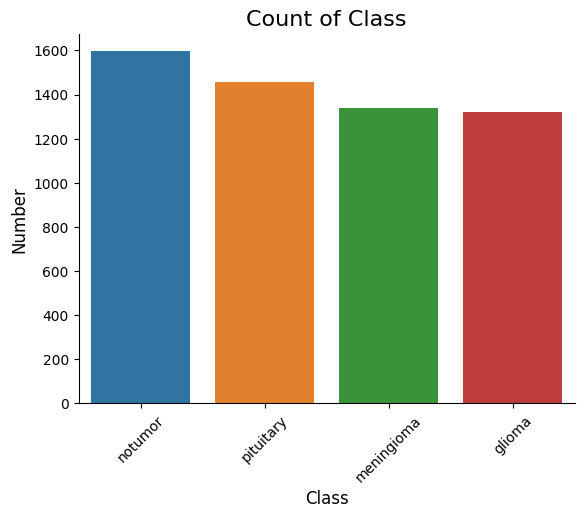

Class
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64


In [4]:
plt.title('Count of Class', size=16)
sns.barplot(x=train_df['Class'].value_counts().index, y=train_df['Class'].value_counts())
plt.ylabel('Number', size=12)
plt.xlabel('Class', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()
print(train_df.Class.value_counts())

In [5]:
dataset_67 = "/kaggle/input/mri067/Brain_Tumor_Detection/no"

file_path_dataset_67 = []
file_class_dataset_67 = []

dataset_67_dirs = os.listdir(dataset_67)

for file in dataset_67_dirs:
    file_path_dataset_67.append(os.path.join(dataset_67, file))
    part_67 = file.split("o")[0]
    if part_67 == "n":
        file_class_dataset_67.append("notumor")
    else:
        file_class_dataset_67.append("notumor")

class_67_df = pd.DataFrame(file_class_dataset_67, columns=['Class'])
path_67_df = pd.DataFrame(file_path_dataset_67, columns=['Path'])
dataset_67_df = pd.concat([class_67_df, path_67_df], axis=1)
print(dataset_67_df.Class.value_counts())
pd.set_option('display.max_colwidth', None)
dataset_67_df

Class
notumor    1500
Name: count, dtype: int64


,Class,Path
0,notumor,/kaggle/input/mri067/Brain_Tumor_Detection/no/no26.jpg
1,notumor,/kaggle/input/mri067/Brain_Tumor_Detection/no/no979.jpg
2,notumor,/kaggle/input/mri067/Brain_Tumor_Detection/no/no598.jpg
3,notumor,/kaggle/input/mri067/Brain_Tumor_Detection/no/no141.jpg
4,notumor,/kaggle/input/mri067/Brain_Tumor_Detection/no/no715.jpg
...,...,...
1495,notumor,/kaggle/input/mri067/Brain_Tumor_Detection/no/no941.jpg
1496,notumor,/kaggle/input/mri067/Brain_Tumor_Detection/no/no853.jpg
1497,notumor,/kaggle/input/mri067/Brain_Tumor_Detection/no/no884.jpg
1498,notumor,/kaggle/input/mri067/Brain_Tumor_Detection/no/no1370.jpg


In [6]:
data_path = pd.concat([train_df, dataset_67_df], axis = 0)

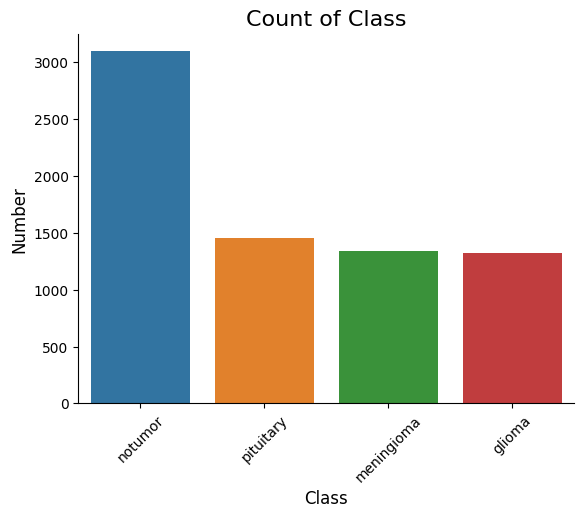

Class
notumor       3095
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64


In [7]:
plt.title('Count of Class', size=16)
sns.barplot(x=data_path['Class'].value_counts().index, y=data_path['Class'].value_counts())
plt.ylabel('Number', size=12)
plt.xlabel('Class', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()
print(data_path.Class.value_counts())

# Augmentation for minority training records

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import pandas as pd

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    return img_array

augmented_data_path = "G:\\Klasyfikacja_Wizja\\Training_augment"
os.makedirs(augmented_data_path, exist_ok=True)

classes = ['pituitary', 'meningioma', 'glioma']
augmentation_factor = 1

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

for class_name in classes:
    class_data = data_path[data_path['Class'] == class_name]
    class_augmented_path = os.path.join(augmented_data_path, class_name)
    os.makedirs(class_augmented_path, exist_ok=True)

    for _, row in class_data.iterrows():
        img_path = row['Path']
        img_name = os.path.basename(img_path)
        new_img_name = f"{class_name}_{img_name}"

        img = load_and_preprocess_image(img_path)
        img = img.reshape((1,) + img.shape)

        i = 0
        for batch in datagen.flow(img, batch_size=1, save_to_dir=class_augmented_path, save_prefix='', save_format='jpg'):
            i += 1
            if i >= augmentation_factor:
                break

In [8]:
dataset_aug = "/kaggle/input/training-augment/Training_augment"

file_path_dataset_aug = []
file_class_dataset_aug = []

dataset_aug_dirs = os.listdir(dataset_aug)

for class_name in dataset_aug_dirs:
    class_path = os.path.join(dataset_aug, class_name)
    if os.path.isdir(class_path):
        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)
            file_path_dataset_aug.append(file_path)
            file_class_dataset_aug.append(class_name)

class_aug_df = pd.DataFrame(file_class_dataset_aug, columns=['Class'])
path_aug_df = pd.DataFrame(file_path_dataset_aug, columns=['Path'])
dataset_aug_df = pd.concat([class_aug_df, path_aug_df], axis=1)
print(dataset_aug_df.Class.value_counts())
pd.set_option('display.max_colwidth', None)
dataset_aug_df

Class
pituitary     1362
meningioma    1267
glioma        1232
Name: count, dtype: int64


,Class,Path
0,pituitary,/kaggle/input/training-augment/Training_augment/pituitary/_0_9839.jpg
1,pituitary,/kaggle/input/training-augment/Training_augment/pituitary/_0_253.jpg
2,pituitary,/kaggle/input/training-augment/Training_augment/pituitary/_0_1837.jpg
3,pituitary,/kaggle/input/training-augment/Training_augment/pituitary/_0_2387.jpg
4,pituitary,/kaggle/input/training-augment/Training_augment/pituitary/_0_2059.jpg
...,...,...
3856,glioma,/kaggle/input/training-augment/Training_augment/glioma/_0_5161.jpg
3857,glioma,/kaggle/input/training-augment/Training_augment/glioma/_0_3255.jpg
3858,glioma,/kaggle/input/training-augment/Training_augment/glioma/_0_4794.jpg
3859,glioma,/kaggle/input/training-augment/Training_augment/glioma/_0_4362.jpg


In [9]:
df_train = pd.concat([data_path, dataset_aug_df], axis = 0)
df_train

,Class,Path
0,pituitary,/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
1,pituitary,/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
2,pituitary,/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
3,pituitary,/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
4,pituitary,/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
...,...,...
3856,glioma,/kaggle/input/training-augment/Training_augment/glioma/_0_5161.jpg
3857,glioma,/kaggle/input/training-augment/Training_augment/glioma/_0_3255.jpg
3858,glioma,/kaggle/input/training-augment/Training_augment/glioma/_0_4794.jpg
3859,glioma,/kaggle/input/training-augment/Training_augment/glioma/_0_4362.jpg


In [10]:
plt.title('Count of Class', size=16)
sns.barplot(x=df_train['Class'].value_counts().index, y=df_train['Class'].value_counts())
plt.ylabel('Number', size=12)
plt.xlabel('Class', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()
print(df_train.Class.value_counts())

Class
notumor       3095
pituitary     2819
meningioma    2606
glioma        2553
Name: count, dtype: int64


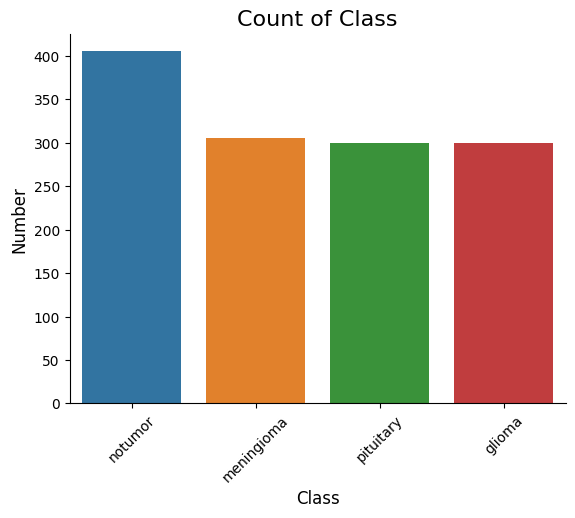

Class
notumor       405
meningioma    306
pituitary     300
glioma        300
Name: count, dtype: int64


In [11]:
plt.title('Count of Class', size=16)
sns.barplot(x=test_df['Class'].value_counts().index, y=test_df['Class'].value_counts())
plt.ylabel('Number', size=12)
plt.xlabel('Class', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()
print(test_df.Class.value_counts())

# Load data for models

In [12]:
datagen_majority = ImageDataGenerator(rescale=1./255)

train_generator = datagen_majority.flow_from_dataframe(
    dataframe=df_train,
    x_col='Path',
    y_col='Class',
    target_size=(224,224),
    batch_size=(32),
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = datagen_majority.flow_from_dataframe(
    dataframe=test_df,
    x_col='Path',
    y_col='Class',
    target_size=(224,224),
    batch_size=(32),
    class_mode='categorical',
    shuffle=True
)

Found 11073 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


# Our CNN model

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(5, 5), strides=(3, 3), padding='same'))

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
model.add(Dropout(0.15))

model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 256)     19456     
                                                                 
 batch_normalization (Batch  (None, 224, 224, 256)     1024      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 128)       295040    
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 128)       512       
 chNormalization)                                                
                                                        

In [19]:
best_model_filepath = 'best_model_our.h5'
model_checkpoint = ModelCheckpoint(
    filepath=best_model_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [20]:
history = model.fit(
    train_generator,
    epochs=75,
    validation_data=validation_generator,
    callbacks=[learning_rate_reduction, model_checkpoint]
)

Epoch 1/75


2024-01-09 21:45:28.976423: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


347/347 [==============================] - ETA: 0s - loss: 1.0877 - accuracy: 0.7568
Epoch 1: val_accuracy improved from -inf to 0.34172, saving model to best_model_our.h5
347/347 [==============================] - 149s 398ms/step - loss: 1.0877 - accuracy: 0.7568 - val_loss: 2.7788 - val_accuracy: 0.3417 - lr: 0.0010
Epoch 2/75


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


347/347 [==============================] - ETA: 0s - loss: 0.5884 - accuracy: 0.8642
Epoch 2: val_accuracy improved from 0.34172 to 0.78413, saving model to best_model_our.h5
347/347 [==============================] - 132s 380ms/step - loss: 0.5884 - accuracy: 0.8642 - val_loss: 0.8173 - val_accuracy: 0.7841 - lr: 0.0010
Epoch 3/75
347/347 [==============================] - ETA: 0s - loss: 0.4136 - accuracy: 0.8907
Epoch 3: val_accuracy did not improve from 0.78413
347/347 [==============================] - 133s 383ms/step - loss: 0.4136 - accuracy: 0.8907 - val_loss: 1.6165 - val_accuracy: 0.5286 - lr: 0.0010
Epoch 4/75
347/347 [==============================] - ETA: 0s - loss: 0.3050 - accuracy: 0.9153
Epoch 4: val_accuracy improved from 0.78413 to 0.88787, saving model to best_model_our.h5
347/347 [==============================] - 133s 383ms/step - loss: 0.3050 - accuracy: 0.9153 - val_loss: 0.3570 - val_accuracy: 0.8879 - lr: 0.0010
Epoch 5/75
347/347 [============================

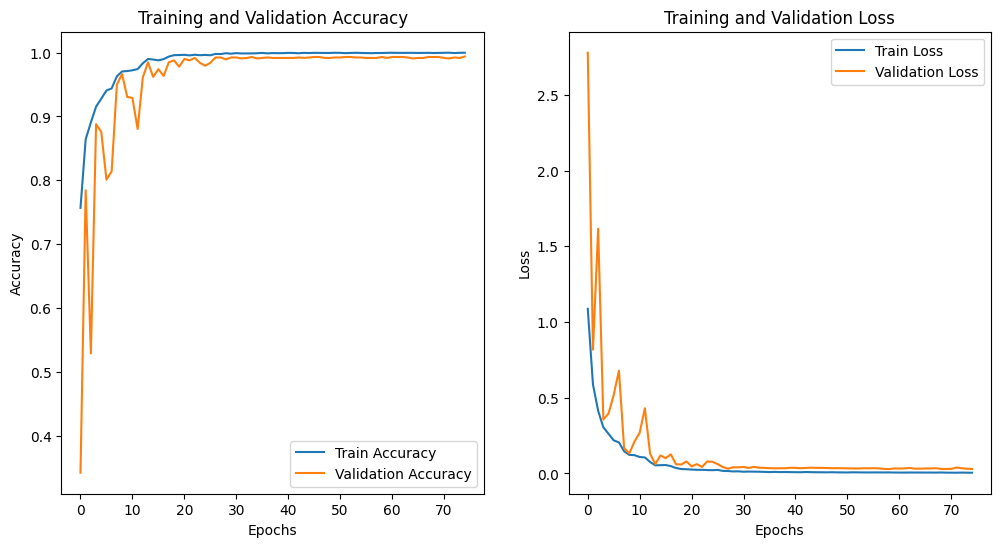

In [21]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [27]:
import pickle

with open('bestmodel_our.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Found 1311 validated image filenames belonging to 4 classes.
41/41 [==============================] - 4s 86ms/step
Test Accuracy: 0.9938977879481312
              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       300
  meningioma       0.98      0.99      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311

Confusion Matrix:
[[296   4   0   0]
 [  1 303   2   0]
 [  0   0 405   0]
 [  0   1   0 299]]


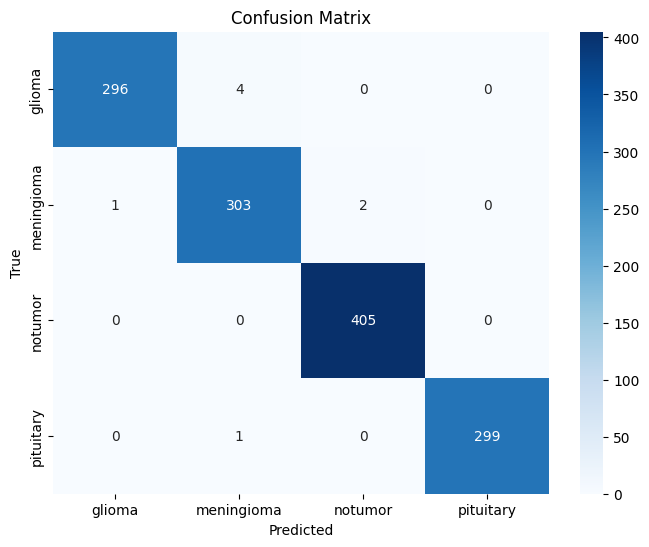

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

datagen_majority = ImageDataGenerator(rescale=1./255)

test_generator = datagen_majority.flow_from_dataframe(
    dataframe=test_df,
    x_col='Path',
    y_col='Class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
) 

predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
class_names = list(test_generator.class_indices.keys())
predicted_class_names = [class_names[i] for i in predicted_classes]
test_accuracy = accuracy_score(test_generator.classes, predicted_classes)
print(f'Test Accuracy: {test_accuracy}')
print(classification_report(test_generator.classes, predicted_classes, target_names=class_names))
conf_mat = confusion_matrix(test_generator.classes, predicted_classes)
print("Confusion Matrix:")
print(conf_mat)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Efficientnet model

In [18]:
efficientnet_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [19]:
for layer in efficientnet_model.layers:
    layer.trainable = False

model_ef = Sequential()
model_ef.add(efficientnet_model)
model_ef.add(Flatten())
model_ef.add(Dense(32, activation='relu'))
model_ef.add(BatchNormalization())
model_ef.add(Dropout(0.25))
model_ef.add(Dense(4, activation='softmax'))

model_ef.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b3 (Functiona  (None, 7, 7, 1536)        10783528  
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 75264)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                2408480   
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 4)                

In [20]:
best_model_filepath = 'best_model_efficient.h5'
model_checkpoint = ModelCheckpoint(
    filepath=best_model_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

model_ef.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [21]:
history_ef = model_ef.fit(
    train_generator,
    epochs=75,
    validation_data=validation_generator,
    callbacks=[learning_rate_reduction, model_checkpoint]
)

Epoch 1/75


2024-01-10 14:02:05.932564: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnet-b3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


347/347 [==============================] - ETA: 0s - loss: 0.9788 - accuracy: 0.8141
Epoch 1: val_accuracy improved from -inf to 0.84363, saving model to best_model_efficient.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


347/347 [==============================] - 108s 275ms/step - loss: 0.9788 - accuracy: 0.8141 - val_loss: 0.7660 - val_accuracy: 0.8436 - lr: 0.0010
Epoch 2/75
347/347 [==============================] - ETA: 0s - loss: 0.7469 - accuracy: 0.8472
Epoch 2: val_accuracy improved from 0.84363 to 0.84897, saving model to best_model_efficient.h5
347/347 [==============================] - 42s 122ms/step - loss: 0.7469 - accuracy: 0.8472 - val_loss: 0.7216 - val_accuracy: 0.8490 - lr: 0.0010
Epoch 3/75
347/347 [==============================] - ETA: 0s - loss: 0.7219 - accuracy: 0.8503
Epoch 3: val_accuracy did not improve from 0.84897
347/347 [==============================] - 41s 119ms/step - loss: 0.7219 - accuracy: 0.8503 - val_loss: 0.8497 - val_accuracy: 0.7918 - lr: 0.0010
Epoch 4/75
347/347 [==============================] - ETA: 0s - loss: 0.7282 - accuracy: 0.8464
Epoch 4: val_accuracy did not improve from 0.84897
347/347 [==============================] - 42s 119ms/step - loss: 0.7282

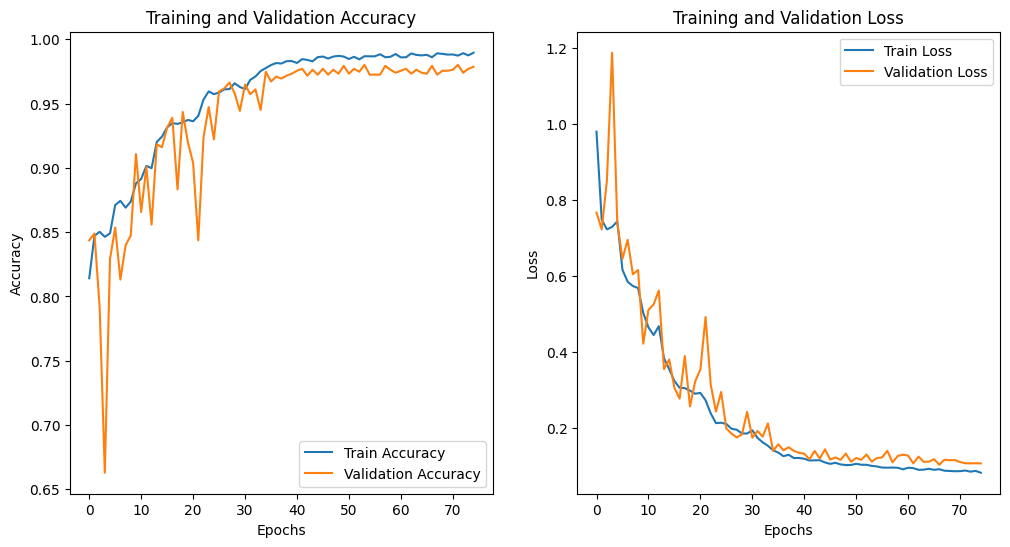

In [22]:
train_accuracy_ef = history_ef.history['accuracy']
val_accuracy_ef = history_ef.history['val_accuracy']
train_loss_ef = history_ef.history['loss']
val_loss_ef = history_ef.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_ef, label='Train Accuracy')
plt.plot(val_accuracy_ef, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_ef, label='Train Loss')
plt.plot(val_loss_ef, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [23]:
import pickle

with open('best_model_efficient.pkl', 'wb') as file:
    pickle.dump(history_ef.history, file)

Found 1311 validated image filenames belonging to 4 classes.
41/41 [==============================] - 6s 100ms/step
Test Accuracy: 0.9786422578184591
              precision    recall  f1-score   support

      glioma       0.99      0.95      0.97       300
  meningioma       0.95      0.96      0.96       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.97      1.00      0.98       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311

Confusion Matrix:
[[285  14   0   1]
 [  3 294   1   8]
 [  0   0 405   0]
 [  1   0   0 299]]


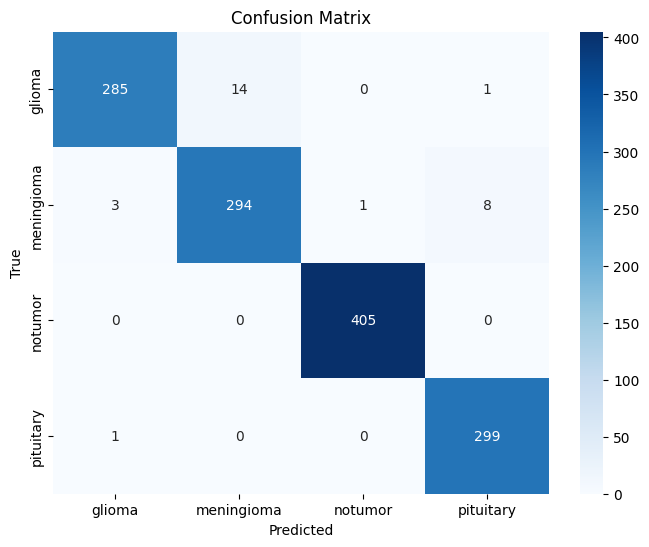

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

datagen_majority = ImageDataGenerator(rescale=1./255)

test_generator = datagen_majority.flow_from_dataframe(
    dataframe=test_df,
    x_col='Path',
    y_col='Class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
) 

predictions = model_ef.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
class_names = list(test_generator.class_indices.keys())
predicted_class_names = [class_names[i] for i in predicted_classes]
test_accuracy = accuracy_score(test_generator.classes, predicted_classes)
print(f'Test Accuracy: {test_accuracy}')
print(classification_report(test_generator.classes, predicted_classes, target_names=class_names))
conf_mat = confusion_matrix(test_generator.classes, predicted_classes)
print("Confusion Matrix:")
print(conf_mat)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Resnet50 model

In [27]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [29]:
for layer in resnet_model.layers:
    layer.trainable = False

In [30]:
model_resnet = Sequential()
model_resnet.add(resnet_model)
model_resnet.add(Flatten())
model_resnet.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model_resnet.add(BatchNormalization())
model_resnet.add(Dropout(0.25))
model_resnet.add(Dense(4, activation='softmax'))

model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 32)                3211296   
                                                                 
 batch_normalization_2 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 4)                 132       
                                                      

In [31]:
best_model_filepath_resnet = 'best_model_resnet.h5'
model_checkpoint_resnet = ModelCheckpoint(
    filepath=best_model_filepath_resnet,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

model_resnet.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

learning_rate_reduction_resnet = ReduceLROnPlateau(monitor='val_accuracy',
                                                   patience=3,
                                                   verbose=1,
                                                   factor=0.5,
                                                   min_lr=0.00001)


In [32]:
history_resnet = model_resnet.fit(
    train_generator,
    epochs=75,
    validation_data=validation_generator,
    callbacks=[learning_rate_reduction_resnet, model_checkpoint_resnet]
)

Epoch 1/75
347/347 [==============================] - ETA: 0s - loss: 0.8131 - accuracy: 0.7207
Epoch 1: val_accuracy improved from -inf to 0.62319, saving model to best_model_resnet.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


347/347 [==============================] - 51s 130ms/step - loss: 0.8131 - accuracy: 0.7207 - val_loss: 1.0876 - val_accuracy: 0.6232 - lr: 0.0010
Epoch 2/75
347/347 [==============================] - ETA: 0s - loss: 0.7103 - accuracy: 0.7622
Epoch 2: val_accuracy did not improve from 0.62319
347/347 [==============================] - 42s 120ms/step - loss: 0.7103 - accuracy: 0.7622 - val_loss: 2.1196 - val_accuracy: 0.4569 - lr: 0.0010
Epoch 3/75
347/347 [==============================] - ETA: 0s - loss: 0.7140 - accuracy: 0.7617
Epoch 3: val_accuracy did not improve from 0.62319
347/347 [==============================] - 41s 119ms/step - loss: 0.7140 - accuracy: 0.7617 - val_loss: 2.7559 - val_accuracy: 0.4172 - lr: 0.0010
Epoch 4/75
347/347 [==============================] - ETA: 0s - loss: 0.7020 - accuracy: 0.7672
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_accuracy did not improve from 0.62319
347/347 [==============================] 

In [33]:
import pickle

with open('history_resnet.pkl', 'wb') as file:
    pickle.dump(history_resnet.history, file)

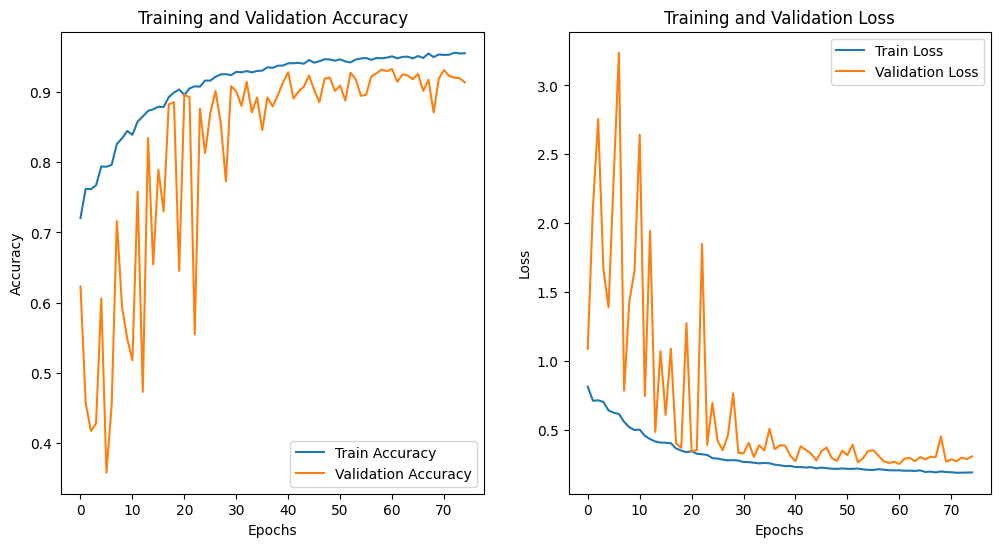

In [34]:
train_accuracy_res = history_resnet.history['accuracy']
val_accuracy_res = history_resnet.history['val_accuracy']
train_loss_res = history_resnet.history['loss']
val_loss_res = history_resnet.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_res, label='Train Accuracy')
plt.plot(val_accuracy_res, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_res, label='Train Loss')
plt.plot(val_loss_res, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Found 1311 validated image filenames belonging to 4 classes.
41/41 [==============================] - 4s 103ms/step
Test Accuracy: 0.9138062547673532
              precision    recall  f1-score   support

      glioma       0.83      0.92      0.87       300
  meningioma       0.92      0.72      0.81       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.89      0.99      0.94       300

    accuracy                           0.91      1311
   macro avg       0.91      0.91      0.90      1311
weighted avg       0.92      0.91      0.91      1311

Confusion Matrix:
[[277  18   0   5]
 [ 54 220   0  32]
 [  2   0 403   0]
 [  2   0   0 298]]


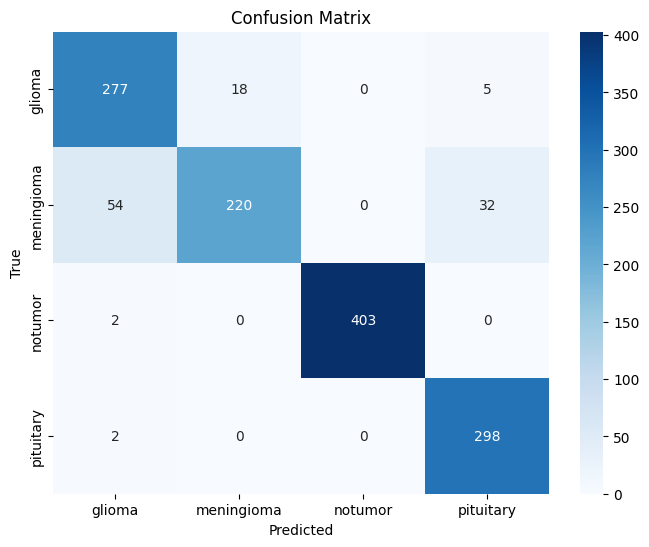

In [36]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

datagen_majority = ImageDataGenerator(rescale=1./255)

test_generator = datagen_majority.flow_from_dataframe(
    dataframe=test_df,
    x_col='Path',
    y_col='Class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
) 

predictions = model_resnet.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
class_names = list(test_generator.class_indices.keys())
predicted_class_names = [class_names[i] for i in predicted_classes]
test_accuracy = accuracy_score(test_generator.classes, predicted_classes)
print(f'Test Accuracy: {test_accuracy}')
print(classification_report(test_generator.classes, predicted_classes, target_names=class_names))
conf_mat = confusion_matrix(test_generator.classes, predicted_classes)
print("Confusion Matrix:")
print(conf_mat)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('best_model.h5')

datagen_majority = ImageDataGenerator(rescale=1./255)
test_generator = datagen_majority.flow_from_dataframe(
    dataframe=test_df,
    x_col='Path',
    y_col='Class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

predictions = loaded_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

display_images_with_labels(test_generator.filepaths, test_generator.classes, predicted_classes, class_names)
plt.show()